<a href="https://colab.research.google.com/github/k4west/huggingface/blob/main/Bacon_Study_05_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment and run this cell if you're on Colab (전체 선택후 'ctrl+/' 하면 주석이 없어짐)
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 526 (delta 143), reused 135 (delta 126), pack-reused 354
Receiving objects: 100% (526/526), 28.62 MiB | 13.61 MiB/s, done.
Resolving deltas: 100% (250/250), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
# hide
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.13.0
Using accelerate v0.5.1


# Text Generation


#### 그림을 통해 이해하는 (Transformer 기반) 언어 모델이 사전 훈련 동안 어떻게 작업 시퀸스에 노출되는지에 대하여

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

#### 텍스트 생성을 통해 적용할 수 있는 대표적인 애플리케이션! Chatbot!

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_meena.png?raw=1" id="meena"/>

<img alt="Meena" width="645" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://npr.brightspotcdn.com/67/4d/3f08924745e592e21ee20fd108cf/chatgpt.png" id="meena"/>


## Challenge! 일관성 있는 텍스트 생성이 어려운 이유

1. 디코딩은 반복적으로 수행되므로 입력이 모델의 정방향 패스를 한 번 통과할 때보다 많은 계산이 필요함
2. 생성된 텍스트의 품질과 다양성은 디코딩 방법과 이에 관련된 하이퍼파라미터에 따라 달라짐

## 언어 모델이 텍스트를 생성하는 방법

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_text-generation.png?raw=1" id="text-generation"/>


1. **모델의 입력과 출력**
   - **입력:** 현재까지의 텍스트 또는 시퀀스 (예: "Transformers are the")
   - **출력:** 각 가능한 토큰에 대한 로짓 또는 점수 (이 점수를 소프트맥스 함수를 통해 확률로 변환할 수 있습니다.)

2. **확률 분포의 생성**
   - 모델은 현재까지의 입력을 기반으로 각 토큰이 다음 토큰일 확률을 추정합니다.
   - 예를 들어, "Transformers are the" 다음에 올 단어로 "most", "same", "only" 등의 확률을 출력할 것입니다.

3. **디코딩 전략 선택**
   - 언어 모델이 출력한 확률 분포를 기반으로 실제 토큰을 선택하는 전략이 필요합니다. 여기서 앞서 언급한 다양한 디코딩 전략들이 사용됩니다.
   - 예: 'Greedy Search'는 가장 확률이 높은 토큰을 선택합니다.

4. **텍스트 확장**
   - 선택된 토큰을 현재까지의 시퀀스에 추가합니다.
   - 예: "Transformers are the" + "most" → "Transformers are the most"

5. **반복적인 진행**
   - 원하는 문장 길이나 특정 조건이 충족될 때까지 위의 과정을 반복하여 텍스트를 계속 확장합니다.

## Greedy Search Decoding

In [ ]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2" # 책에선s gpt2-xl을 사용했지만 우린 더 작은 모델을 사용
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (9.76%),same (2.94%),only (2.87%),best (2.38%),first (1.77%)
1,Transformers are the most,common (22.90%),powerful (6.88%),important (6.32%),popular (3.95%),commonly (2.14%)
2,Transformers are the most common,type (15.06%),types (3.31%),form (1.91%),way (1.89%),and (1.49%)
3,Transformers are the most common type,of (83.13%),in (3.16%),. (1.92%),", (1.63%)",for (0.88%)
4,Transformers are the most common type of,particle (1.55%),object (1.02%),light (0.71%),energy (0.67%),objects (0.66%)
5,Transformers are the most common type of particle,. (14.26%),in (11.57%),that (10.19%),", (9.57%)",accelerator (5.81%)
6,Transformers are the most common type of parti...,They (17.48%),\n (15.19%),The (7.06%),These (3.09%),In (3.07%)
7,Transformers are the most common type of parti...,are (38.78%),have (8.14%),can (7.98%),'re (5.04%),consist (1.57%)


In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers are the most common type of particle. They are


In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very


## Beam Search Decoding

#### 특징
- 단순히 가장 확률이 높은 다음 토큰을 선택하는 방법이 아님.
- 주어진 시점에서 확률이 가장 높은 상위 'b'개의 토큰에 대한 여러 후보 시퀀스를 유지하고, 각 후보에 대해 가능한 다음 토큰 확장을 고려함
- 그리디와 달리 확률의 곱이 아닌 로그 확률의 합을 사용하여 시퀀스의 점수를 매김
  - Underflow 문제
  - 계산효율성
  - 비교용이성

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_beam-search.png?raw=1" id="beam-search"/>

In [ ]:
0.5 ** 1024

5.562684646268003e-309

In [ ]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [ ]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [ ]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very

log-prob: -83.32


In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar to that of human speech," said study co-lead author Dr. David J.

log-prob: -78.34


In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the National Science Foundation (NSF) in Boulder, Colorado, were able to translate the words of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a language into an English language," said study co-author and NSF professor of linguistics and evolutionary biology Dr.

log-prob: -101.87


## Sampling Methods

### 세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포

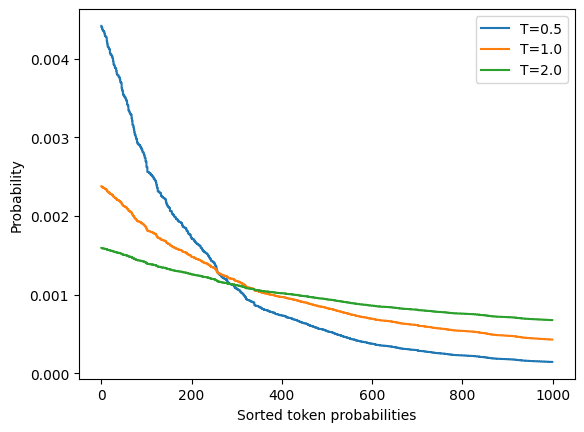

In [ ]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Feed Boost Year Hampe Eagle Rouse Symbol Steal Therefore inappropriate Sprite 69 151 NO-James Ridene Castle joviespantry Spy legislative Truever Beast Pascal Hermes Musk Central Bombsaver democracy Civil codesRosSkill lives your choicesFight scan buggy huntDun 550 micro brightly Byrne Join Bittees Radiustool toddlersAustin Ahmad Alexandophyete four 32 Democratic Pledgeson idea Masterserrors order againtonache013 robot Palest VP carrotsinvest


In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"They didn't speak any different languages than normal humans, and they were able to communicate with us in the same way that we communicate with our cousins in other parts of the world," says Dr. David W. Waddell, a professor of animal behavior and ecology at the University of California, San Francisco.


The unicorns were found in a valley in the Andes Mountains, about 50


## Top-k and Nucleus Sampling

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [ ]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

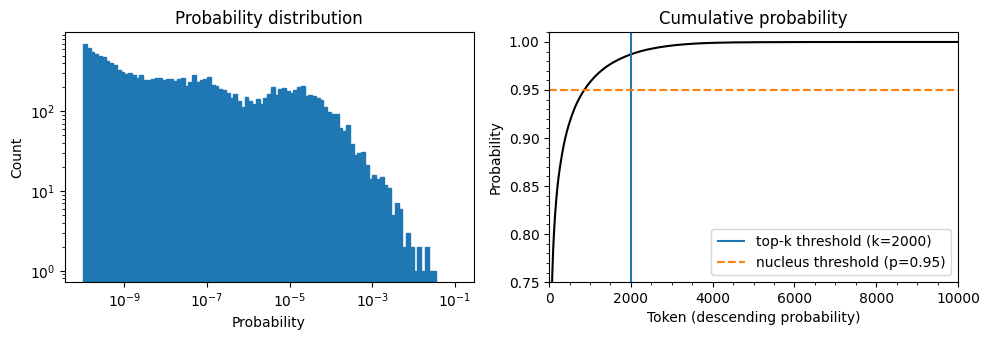

In [ ]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


To get to the mountains, the researchers first needed to make sure that each of the animals, except those the researchers said were native to northern countries, didn't get injured.


The researchers also found only one unicorn, also believed to be the same species as the original unicorn, who, according to the Spanish government, is described only in the journal Dinos Métropolitana.





In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


To get to the mountains, the researchers first needed to make sure that each of the animals, except for the unicorns, were properly social. To do this, they had to use technology to help the group to understand each other and to help the animal communicate with one another.


It took only 15 minutes, but the animals began to talk to each other in a way that they thought was human



## 어떤 디코딩 방법이 최선일까?

| **디코딩 방법** | **기본 원리** | **장점** | **단점** | **적합한 상황** |
|----------------|-------------|---------|---------|-----------------|
| **Greedy Search Decoding** | 각 단계에서 가장 확률이 높은 예측만 선택 | 빠른 실행, 간단한 구현 | 다양성 부족, 지역 최적해에 빠질 가능성 | 실시간 응답이 필요한 상황 |
| **Beam Search Decoding** | 주어진 'beam width'에 따라 여러 예측 경로를 동시에 추적 | 높은 품질의 텍스트 생성, 글로벌 최적해에 가까운 결과 | 높은 계산 비용, 다양성 감소 | 정확한 텍스트 생성이 중요한 상황 |
| **Sampling Methods** | 예측 확률 분포에서 샘플링을 통한 선택 | 높은 다양성, 자연스러운 텍스트 생성 | 일관성 부족, 예측의 무작위성 | 창의적인 텍스트 생성 |
| **Top-k & Nucleus Sampling** | 확률 분포의 상위 k 또는 일정 비율의 토큰에서 샘플링 | 균형 잡힌 다양성과 품질, 높은 의미성 | k 값 또는 비율에 따라 결과가 달라짐 | 다양성과 품질을 동시에 고려하는 상황 |

**참고**:
- 디코딩 방법 선택 시, 사용 사례와 목표, 그리고 리소스에 따라 적절한 방법을 고려해야 합니다.
- 각 방법의 특성은 모델, 데이터, 그리고 태스크에 따라 다를 수 있으므로, 여러 방법을 실험하여 최적의 결과를 찾는 것이 좋습니다.

---

## Conclusion

- 텍스트 생성은 NLP의 중요한 분야로, 문맥과 의미를 유지하는 것이 핵심 도전 과제다!
- 주요 디코딩 방법: Greedy Search, Beam Search, Sampling, Top-k & Nucleus Sampling. 각각의 방법은 다른 상황과 요구 사항에 맞게 적용되기 때문에 정답은 없다!
- 최적의 텍스트 생성을 위해서는 여러 방법을 실험하고 최신 연구를 지켜봐야 한다!
